[Joseph Josia](https://www.kaggle.com/takanashihumbert)님의 [magic bingo train part [LB 0.687]](https://www.kaggle.com/code/takanashihumbert/magic-bingo-train-part-lb-0-687)을 분석했습니다.

I'm glad to share my plan. This is based on the landmark notebook by Chris [Here](https://www.kaggle.com/code/cdeotte/xgboost-baseline-0-676). Thanks to him and all the participants who share their ideas.
My inference part is [Here](https://www.kaggle.com/code/takanashihumbert/magic-bingo-inference-part-lb-0-687)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
# pickle은 리스트나 딕셔너리 형태의 데이터를 저장할 때 사용하는 라이브러리입니다.
import pickle
# polars는 데이터의 크기가 클 때, pandas의 read_csv보다 시간과 메모리를 많이 절약할 수 있는 라이브러리입니다.
import polars as pl
from sklearn.model_selection import KFold, GroupKFold
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm
from collections import defaultdict
import warnings
from itertools import combinations

warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

In [4]:
targets = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]))
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]))
print(targets.shape)

(424116, 4)


In [5]:
%%time
columns = [
    # col은 기존 또는 새로운 변수명, cast는 변수타입
    pl.col("page").cast(pl.Float32),
    (
        # shift(1)는 데이터를 아래로 한 칸 내립니다. 즉 이후 데이터와의 차이를 만들어 냅니다.
        (pl.col("elapsed_time") - pl.col("elapsed_time").shift(1)) # time used for each action
         # 결측값은 0으로
         .fill_null(0)
         # 데이터가 0이하이면 0으로, 1e9이상이면 1e9으로 만듭니다.
         .clip(0, 1e9)
         # session_id, level_group 별로(python에서 groupby와 동일합니다.)
         .over(["session_id", "level_group"])
         # 변수명을 정의합니다.
         .alias("elapsed_time_diff")
    ),
    (
        (pl.col("screen_coor_x") - pl.col("screen_coor_x").shift(1)) # location x changed for click 
         .abs()
         .over(["session_id", "level_group"])
    ),
    (
        (pl.col("screen_coor_y") - pl.col("screen_coor_y").shift(1)) # location y changed for click 
         .abs()
         .over(["session_id", "level_group"])
    ),
    # 결측값들을 각각 'fqid_None', 'text_fqid_None'으로 변환합니다.
    pl.col("fqid").fill_null("fqid_None"),
    pl.col("text_fqid").fill_null("text_fqid_None")
]

# polars는 read_parquet으로 불러옵니다.
df = (pl.read_parquet("/kaggle/input/game-play-train-parquet/train.parquet")
      .drop(["fullscreen", "hq", "music"])
      # with_colmns으로 위 피처를 더합니다.
      .with_columns(columns))

# filter함수로 미리 level_group별 데이터를 정의합니다.
df1 = df.filter(pl.col("level_group")=='0-4')
df2 = df.filter(pl.col("level_group")=='5-12')
df3 = df.filter(pl.col("level_group")=='13-22')

CPU times: user 12 s, sys: 8.51 s, total: 20.5 s
Wall time: 14.8 s


In [12]:
df

session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,level_group,elapsed_time_diff
i64,i16,i32,str,str,i8,f32,f32,f32,f32,f32,f32,str,str,str,str,str,i32
20090312431273200,0,0,"""cutscene_click...","""basic""",0,null,-414.0,-159.375,null,null,null,"""undefined""","""intro""","""tunic.historic...","""tunic.historic...","""0-4""",0
20090312431273200,1,1323,"""person_click""","""basic""",0,null,-414.0,-159.375,0.0,0.0,null,"""Whatcha doing ...","""gramps""","""tunic.historic...","""tunic.historic...","""0-4""",1323
20090312431273200,2,831,"""person_click""","""basic""",0,null,-414.0,-159.375,0.0,0.0,null,"""Just talking t...","""gramps""","""tunic.historic...","""tunic.historic...","""0-4""",0
20090312431273200,3,1147,"""person_click""","""basic""",0,null,-414.0,-159.375,0.0,0.0,null,"""I gotta run to...","""gramps""","""tunic.historic...","""tunic.historic...","""0-4""",316
20090312431273200,4,1863,"""person_click""","""basic""",0,null,-413.0,-159.375,1.0,0.0,null,"""Can I come, Gr...","""gramps""","""tunic.historic...","""tunic.historic...","""0-4""",716
20090312431273200,5,3423,"""person_click""","""basic""",0,null,-413.0,-157.375,0.0,2.0,null,"""Sure thing, Jo...","""gramps""","""tunic.historic...","""tunic.historic...","""0-4""",1560
20090312431273200,6,5197,"""person_click""","""basic""",0,null,478.5,-200.0,212.0,7.0,null,"""See you later,...","""teddy""","""tunic.historic...","""tunic.historic...","""0-4""",1774
20090312431273200,7,6180,"""person_click""","""basic""",0,null,503.25,-168.625,16.0,32.0,null,"""I get to go to...","""teddy""","""tunic.historic...","""tunic.historic...","""0-4""",983
20090312431273200,8,7014,"""person_click""","""basic""",0,null,510.75,-157.75,6.0,11.0,null,"""Now where did ...","""teddy""","""tunic.historic...","""tunic.historic...","""0-4""",834


In [13]:
CATS = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']

event_name_feature = ['cutscene_click', 'person_click', 'navigate_click',
       'observation_click', 'notification_click', 'object_click',
       'object_hover', 'map_hover', 'map_click', 'checkpoint',
       'notebook_click']

# 기존 BASE XGB MODEL에서 name의 고윳값을 추가합니다.
name_feature = ['basic', 'undefined', 'close', 'open', 'prev', 'next']

NUMS = [ 
    'page', 
    'room_coor_x', 
    'room_coor_y', 
    'screen_coor_x', 
    'screen_coor_y', 
    'hover_duration', 
    'elapsed_time_diff'
]

Here are some useful features:
* event numbers for each sessions
* average, minimum and maximum time consumed for each 'event_name' and 'name'
* features about 'bingo'(when users successfully click the correct place and finish the phased games), which can be translated as comprehension and deductive ability.

In [14]:
def feature_engineer(x, grp, use_extra, feature_suffix):

    aggs = [
        pl.col("index").count().alias(f"session_number_{feature_suffix}"), # index 피처의 개수
        *[pl.col(c).drop_nulls().n_unique().alias(f"{c}_unique_{feature_suffix}") for c in CATS], # 명목형 변수의 고윳값 갯수
        *[pl.col(c).mean().alias(f"{c}_mean_{feature_suffix}") for c in NUMS], # 수치형 변수의 평균
        *[pl.col(c).min().alias(f"{c}_min_{feature_suffix}") for c in NUMS], # 수치형 변수의 최솟값
        *[pl.col(c).max().alias(f"{c}_max_{feature_suffix}") for c in NUMS], # 수치형 변수의 최댓값
        # 'event_name'과 'name' 고윳값에 대한 'elapsed_time_diff'의 평균, 최댓값, 최솟값
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name")==c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name")==c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name")==c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name")==c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name")==c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name")==c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in name_feature],
    ]
    
    # session_id 별로 위 도구들을 이용합니다.
    df = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
    
    if use_extra:
        if grp=='5-12':
            aggs = [
                # text, fqid에 bingo가 있는 데이터들을 모아서 elapsed_time, indexcount들의 duration 피처 생성
                pl.col("elapsed_time").filter((pl.col("text")=="Here's the log book.")|(pl.col("fqid")=='logbook.page.bingo')).apply(lambda s: s.max()-s.min()).alias("logbook_bingo_duration"),
                pl.col("index").filter((pl.col("text")=="Here's the log book.")|(pl.col("fqid")=='logbook.page.bingo')).apply(lambda s: s.max()-s.min()).alias("logbook_bingo_indexCount"),
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader'))|(pl.col("fqid")=="reader.paper2.bingo")).apply(lambda s: s.max()-s.min()).alias("reader_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader'))|(pl.col("fqid")=="reader.paper2.bingo")).apply(lambda s: s.max()-s.min()).alias("reader_bingo_indexCount"),
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals'))|(pl.col("fqid")=="journals.pic_2.bingo")).apply(lambda s: s.max()-s.min()).alias("journals_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals'))|(pl.col("fqid")=="journals.pic_2.bingo")).apply(lambda s: s.max()-s.min()).alias("journals_bingo_indexCount"),
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            # session_id를 기준으로 left에 붙이기
            df = df.join(tmp, on="session_id", how='left')

        if grp=='13-22':
            aggs = [
                # bingo 또는 정답 데이터들을 모아서 elapsed_time, indexcount들의 duration 피처 생성
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader_flag'))|(pl.col("fqid")=="tunic.library.microfiche.reader_flag.paper2.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("reader_flag_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader_flag'))|(pl.col("fqid")=="tunic.library.microfiche.reader_flag.paper2.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("reader_flag_indexCount"),
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals_flag'))|(pl.col("fqid")=="journals_flag.pic_0.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("journalsFlag_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals_flag'))|(pl.col("fqid")=="journals_flag.pic_0.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("journalsFlag_bingo_indexCount")
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')
        
    return df.to_pandas()

In [15]:
%%time
df1 = feature_engineer(df1, grp='0-4', use_extra=True, feature_suffix='')
print('df1 done')
df2 = feature_engineer(df2, grp='5-12', use_extra=True, feature_suffix='')
print('df2 done')
df3 = feature_engineer(df3, grp='13-22', use_extra=True, feature_suffix='')
print('df3 done')

df1 done
df2 done
df3 done
CPU times: user 17.8 s, sys: 3.51 s, total: 21.4 s
Wall time: 13.3 s


Remove some redundant features

In [24]:
df2['navigate_click_ET_min_']

0        0
1        0
2        0
3        0
4        0
        ..
11774    0
11775    0
11776    0
11777    0
11778    0
Name: navigate_click_ET_min_, Length: 11779, dtype: int32

In [21]:
null1 = df1.isnull().sum().sort_values(ascending=False) / len(df1)
null2 = df2.isnull().sum().sort_values(ascending=False) / len(df1)
null3 = df3.isnull().sum().sort_values(ascending=False) / len(df1)

# 결측값들이 90% 이상인 피처들을 구합니다.
drop1 = list(null1[null1>0.9].index)
drop2 = list(null2[null2>0.9].index)
drop3 = list(null3[null3>0.9].index)
print(len(drop1), len(drop2), len(drop3))

for col in tqdm(df1.columns):
    # 만약 피처값이 1개 뿐일 경우(데이터들이 다 0)
    if df1[col].nunique()==1:
        print(col)
        drop1.append(col)
print("*********df1 DONE*********")
for col in tqdm(df2.columns):
    if df2[col].nunique()==1:
        print(col)
        drop2.append(col)
print("*********df2 DONE*********")
for col in tqdm(df3.columns):
    if df3[col].nunique()==1:
        print(col)
        drop3.append(col)
print("*********df3 DONE*********")

6 3 0


  0%|          | 0/79 [00:00<?, ?it/s]

elapsed_time_diff_min_
*********df1 DONE*********


  0%|          | 0/85 [00:00<?, ?it/s]

elapsed_time_diff_min_
navigate_click_ET_min_
undefined_ET_min_
*********df2 DONE*********


  0%|          | 0/83 [00:00<?, ?it/s]

elapsed_time_diff_min_
navigate_click_ET_min_
undefined_ET_min_
*********df3 DONE*********


In [25]:
df1 = df1.set_index('session_id')
df2 = df2.set_index('session_id')
df3 = df3.set_index('session_id')

In [26]:
# drop 피처와 level_group을 제외한 나머지 피처들을 정의합니다. 
FEATURES1 = [c for c in df1.columns if c not in drop1+['level_group']]
FEATURES2 = [c for c in df2.columns if c not in drop2+['level_group']]
FEATURES3 = [c for c in df3.columns if c not in drop3+['level_group']]
print('We will train with', len(FEATURES1), len(FEATURES2), len(FEATURES3) ,'features')
ALL_USERS = df1.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 71 78 79 features
We will train with 11779 users info


In [28]:
%%time
gkf = GroupKFold(n_splits=5)
oof_xgb = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS, columns=[f'meta_{i}' for i in range(1, 19)])
#models = {}
best_iteration_xgb = defaultdict(list)
importance_dict = {}

# ITERATE THRU QUESTIONS 1 THRU 18
for t in range(1,19):

    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3: 
        grp = '0-4'
        df = df1
        FEATURES = FEATURES1
    elif t<=13: 
        grp = '5-12'
        df = df2
        FEATURES = FEATURES2
    elif t<=22: 
        grp = '13-22'
        df = df3
        FEATURES = FEATURES3
        
    print('#'*25)
    print('### question', t, 'with features', len(FEATURES))
    print('#'*25)
    
    # 파라미터를 그리디 최적화 or 베이지안 최적화를 수행할 수 있습니다.
    xgb_params = {
        'booster': 'gbtree',
        'objective': 'binary:logistic',
        'tree_method': 'gpu_hist',
        'eval_metric':'logloss',
        'learning_rate': 0.02,
        'alpha': 8,
        'max_depth': 4,
        'n_estimators': 9999,
        'early_stopping_rounds': 90,
        'subsample':0.8,
        'colsample_bytree': 0.5,
        'seed': 42
    }

    feature_importance_df = pd.DataFrame()
    # COMPUTE CV SCORE WITH 5 GROUP K FOLD
    for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):
        
        # TRAIN DATA
        train_x = df.iloc[train_index]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = df.iloc[test_index]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]
        
        # TRAIN MODEL        
        clf =  XGBClassifier(**xgb_params)
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'],
                eval_set=[(valid_x[FEATURES].astype('float32'), valid_y['correct'])],
                verbose=0)
        print(i+1, ', ', end='')
        # best_iteration을 저장합니다.
        best_iteration_xgb[str(t)].append(clf.best_ntree_limit)
        
        # 각 모델 별 피처들의 중요도를 저장합니다.
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = FEATURES
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        # SAVE MODEL, PREDICT VALID OOF
        # oof_xgb에 확률값들을 저장합니다.
        oof_xgb.loc[valid_users, f'meta_{t}'] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
            

    print()
    feature_importance_df = feature_importance_df.groupby(['feature'])['importance'].agg(['mean']).sort_values(by='mean', ascending=False)
    display(feature_importance_df.head(10))

#########################
### question 1 with features 71
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
checkpoint_ET_max_,0.057399
session_number_,0.041638
checkpoint_ET_mean_,0.039649
cutscene_click_ET_mean_,0.034663
checkpoint_ET_min_,0.033978
basic_ET_max_,0.032074
basic_ET_mean_,0.025792
page_min_,0.025676
elapsed_time_diff_max_,0.024990


#########################
### question 2 with features 71
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.041155
checkpoint_ET_max_,0.035366
object_click_ET_min_,0.031983
person_click_ET_min_,0.031416
checkpoint_ET_min_,0.028881
checkpoint_ET_mean_,0.028077
basic_ET_max_,0.021443
cutscene_click_ET_mean_,0.020981
basic_ET_mean_,0.018322


#########################
### question 3 with features 71
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.039692
checkpoint_ET_mean_,0.032471
checkpoint_ET_min_,0.030740
checkpoint_ET_max_,0.030585
basic_ET_mean_,0.025717
basic_ET_max_,0.022118
object_click_ET_mean_,0.021640
cutscene_click_ET_mean_,0.019329
person_click_ET_mean_,0.018723


#########################
### question 4 with features 78
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.071007
person_click_ET_min_,0.054817
person_click_ET_mean_,0.048478
text_fqid_unique_,0.036635
reader_bingo_indexCount,0.031001
journals_bingo_indexCount,0.024539
cutscene_click_ET_min_,0.024135
page_max_,0.020340
logbook_bingo_indexCount,0.020101


#########################
### question 5 with features 78
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.082091
text_fqid_unique_,0.047291
journals_bingo_indexCount,0.043275
journals_bingo_duration,0.029241
room_fqid_unique_,0.024457
reader_bingo_indexCount,0.021366
person_click_ET_min_,0.019903
person_click_ET_mean_,0.019219
observation_click_ET_max_,0.018620


#########################
### question 6 with features 78
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.092467
text_fqid_unique_,0.047947
journals_bingo_indexCount,0.041473
reader_bingo_indexCount,0.031266
journals_bingo_duration,0.027762
logbook_bingo_indexCount,0.022012
room_fqid_unique_,0.019876
observation_click_ET_max_,0.018315
person_click_ET_min_,0.017154


#########################
### question 7 with features 78
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.065410
text_fqid_unique_,0.043814
reader_bingo_indexCount,0.031159
journals_bingo_indexCount,0.027485
observation_click_ET_max_,0.022851
room_fqid_unique_,0.022509
journals_bingo_duration,0.019056
hover_duration_mean_,0.018025
person_click_ET_min_,0.017988


#########################
### question 8 with features 78
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.041119
text_fqid_unique_,0.039162
room_fqid_unique_,0.021510
journals_bingo_duration,0.020684
reader_bingo_duration,0.018744
fqid_unique_,0.018658
journals_bingo_indexCount,0.017862
observation_click_ET_mean_,0.017839
object_click_ET_min_,0.017399


#########################
### question 9 with features 78
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.075030
text_fqid_unique_,0.050023
journals_bingo_indexCount,0.040521
room_fqid_unique_,0.030901
journals_bingo_duration,0.025188
reader_bingo_indexCount,0.022321
person_click_ET_min_,0.019873
observation_click_ET_max_,0.018552
hover_duration_mean_,0.017620


#########################
### question 10 with features 78
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.076694
journals_bingo_indexCount,0.042425
text_fqid_unique_,0.039192
journals_bingo_duration,0.028726
reader_bingo_indexCount,0.026222
room_fqid_unique_,0.025441
person_click_ET_mean_,0.017866
observation_click_ET_max_,0.017017
person_click_ET_min_,0.015955


#########################
### question 11 with features 78
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.062441
journals_bingo_indexCount,0.038455
journals_bingo_duration,0.036266
reader_bingo_indexCount,0.027020
observation_click_ET_max_,0.024726
room_fqid_unique_,0.021873
text_fqid_unique_,0.020285
checkpoint_ET_min_,0.015892
observation_click_ET_mean_,0.015862


#########################
### question 12 with features 78
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.048769
reader_bingo_indexCount,0.029191
text_fqid_unique_,0.028531
person_click_ET_min_,0.022576
logbook_bingo_duration,0.017716
hover_duration_mean_,0.017301
observation_click_ET_max_,0.017260
logbook_bingo_indexCount,0.016714
basic_ET_min_,0.016683


#########################
### question 13 with features 78
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
journals_bingo_duration,0.065910
journals_bingo_indexCount,0.064778
room_fqid_unique_,0.044192
reader_bingo_duration,0.037865
session_number_,0.030248
logbook_bingo_duration,0.029379
fqid_unique_,0.024915
object_click_ET_max_,0.017921
object_click_ET_min_,0.017520


#########################
### question 14 with features 79
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
room_fqid_unique_,0.069515
session_number_,0.063372
text_fqid_unique_,0.060456
hover_duration_mean_,0.017829
cutscene_click_ET_mean_,0.017575
cutscene_click_ET_min_,0.016558
person_click_ET_max_,0.016189
notification_click_ET_max_,0.015511
observation_click_ET_max_,0.014288


#########################
### question 15 with features 79
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
room_fqid_unique_,0.085606
session_number_,0.055821
text_fqid_unique_,0.043548
person_click_ET_min_,0.022236
observation_click_ET_max_,0.021824
cutscene_click_ET_mean_,0.019608
person_click_ET_mean_,0.017823
person_click_ET_max_,0.016974
notification_click_ET_max_,0.016286


#########################
### question 16 with features 79
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.022043
journalsFlag_bingo_indexCount,0.018156
person_click_ET_mean_,0.016536
hover_duration_mean_,0.016279
observation_click_ET_min_,0.016029
room_fqid_unique_,0.015666
cutscene_click_ET_mean_,0.015173
person_click_ET_min_,0.015123
observation_click_ET_mean_,0.014981


#########################
### question 17 with features 79
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.024449
close_ET_mean_,0.024409
basic_ET_mean_,0.020043
journalsFlag_bingo_duration,0.019413
person_click_ET_mean_,0.019362
notification_click_ET_mean_,0.018211
text_fqid_unique_,0.018008
next_ET_min_,0.017351
person_click_ET_min_,0.017301


#########################
### question 18 with features 79
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.053575
room_fqid_unique_,0.037389
text_fqid_unique_,0.025741
person_click_ET_max_,0.021658
observation_click_ET_mean_,0.016530
close_ET_mean_,0.016507
map_click_ET_max_,0.016425
person_click_ET_mean_,0.015391
cutscene_click_ET_mean_,0.014722


CPU times: user 1min 49s, sys: 1.8 s, total: 1min 51s
Wall time: 1min 45s


In [34]:
(oof_xgb.values.reshape(-1)>0.4).astype('int')

array([1, 1, 1, ..., 1, 1, 1])

0.400, 0.405, 0.410, 0.415, 0.420, 0.425, 0.430, 0.435, 0.440, 0.445, 0.450, 0.455, 0.460, 0.465, 0.470, 0.475, 0.480, 0.485, 0.490, 0.495, 0.500, 0.505, 0.510, 0.515, 0.520, 0.525, 0.530, 0.535, 0.540, 0.545, 0.550, 0.555, 0.560, 0.565, 0.570, 0.575, 0.580, 0.585, 0.590, 0.595, 0.600, 0.605, 0.610, 0.615, 0.620, 0.625, 0.630, 0.635, 0.640, 0.645, 0.650, 0.655, 0.660, 0.665, 0.670, 0.675, 0.680, 0.685, 0.690, 0.695, 0.700, 0.705, 0.710, 0.715, 0.720, 0.725, 0.730, 0.735, 0.740, 0.745, 0.750, 0.755, 0.760, 0.765, 0.770, 0.775, 0.780, 0.785, 0.790, 0.795, 0.800, 0.805, 

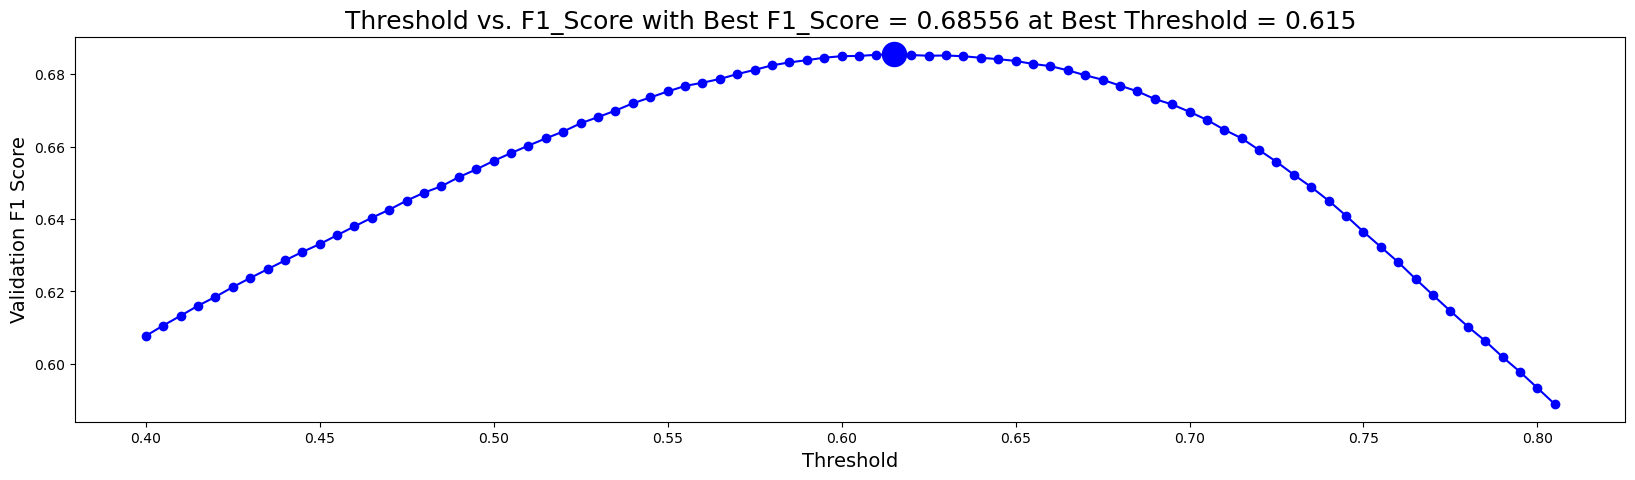

In [35]:
true = oof_xgb.copy()
for i in range(1, 19):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q==i].set_index('session').loc[ALL_USERS]
    true[f'meta_{i}'] = tmp.correct.values

# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score_xgb = 0; best_threshold_xgb = 0

for threshold in np.arange(0.4,0.81,0.005): # 쓰래드의 범위를 0.4부터 0.81까지 0.005만큼 오르게 합니다.
    print(f'{threshold:.03f}, ',end='')
    preds = (oof_xgb.values.reshape((-1))>threshold).astype('int')
    # f1_socre 'macro' 공부
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score_xgb:
        best_score_xgb = m
        best_threshold_xgb = threshold

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold_xgb], [best_score_xgb], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score_xgb:.5f} at Best Threshold = {best_threshold_xgb:.4}',size=18)
plt.show()

Now we use full data to retrain our models with the best iterations, and save them. 

In [38]:
%%time
# ITERATE THRU QUESTIONS 1 THRU 18
for t in range(1,19):

    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3: 
        grp = '0-4'
        df = df1
        FEATURES = FEATURES1
    elif t<=13: 
        grp = '5-12'
        df = df2
        FEATURES = FEATURES2
    elif t<=22: 
        grp = '13-22'
        df = df3
        FEATURES = FEATURES3
    
    # 이전에 얻은 best_iteration을 사용합니다.
    n_estimators = int(np.median(best_iteration_xgb[str(t)]) + 1)
    xgb_params = {
        'objective': 'binary:logistic',
        'tree_method': 'gpu_hist',
        'eval_metric':'logloss',
        'learning_rate': 0.02,
        'alpha': 8,
        'max_depth': 4,
        'n_estimators': n_estimators,
        'subsample':0.8,
        'colsample_bytree': 0.5,
        'use_label_encoder': False
    }
    
    print('#'*25)
    print(f'### question {t} features {len(FEATURES)}')
        
    # TRAIN DATA
    train_users = df.index.values
    train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]

    # TRAIN MODEL        
    clf =  XGBClassifier(**xgb_params)
    clf.fit(df[FEATURES].astype('float32'), train_y['correct'], verbose=0)
    clf.save_model(f'XGB_question{t}.xgb')
    
    print()

#########################
### question 1 features 71

#########################
### question 2 features 71

#########################
### question 3 features 71

#########################
### question 4 features 78

#########################
### question 5 features 78

#########################
### question 6 features 78

#########################
### question 7 features 78

#########################
### question 8 features 78

#########################
### question 9 features 78

#########################
### question 10 features 78

#########################
### question 11 features 78

#########################
### question 12 features 78

#########################
### question 13 features 78

#########################
### question 14 features 79

#########################
### question 15 features 79

#########################
### question 16 features 79

#########################
### question 17 features 79

#########################
### question 18 features 79

CPU times: user 12.

We save features names as dict for each questions

In [43]:
# level_group별 피처를 저장합니다.
importance_dict = {}
for t in range(1, 19):
    if t<=3: 
        importance_dict[str(t)] = FEATURES1
    elif t<=13: 
        importance_dict[str(t)] = FEATURES2
    elif t<=22:
        importance_dict[str(t)] = FEATURES3

f_save = open('importance_dict.pkl', 'wb')
# pickle 공부
pickle.dump(importance_dict, f_save)
f_save.close()